In [28]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks

In [91]:
stock_name = "AAPL"

[*********************100%%**********************]  1 of 1 completed


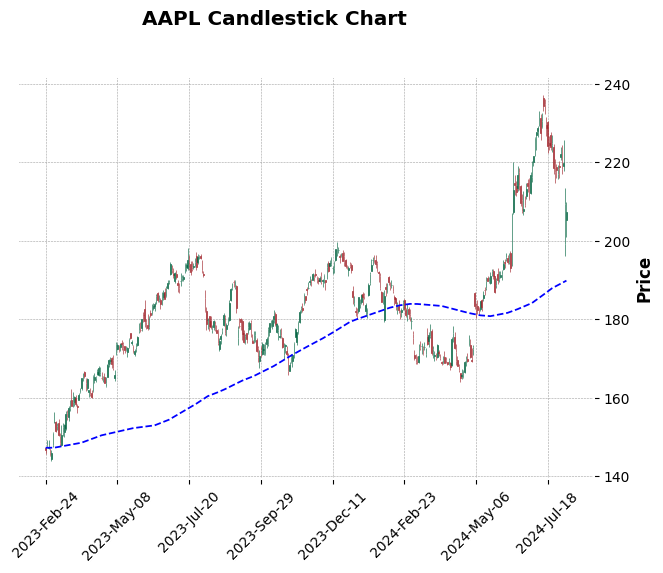

,Open,High,Low,Close,Volume,last_close,200_day,movement
Date,,,,,,,,
2023-02-24,147.110001,147.190002,145.720001,146.710007,55469600,149.399994,147.20060,-0.399994
2023-02-27,147.710007,149.169998,147.449997,147.919998,44998500,146.710007,147.16765,0.209991
2023-02-28,147.050003,149.080002,146.830002,147.410004,50547000,147.919998,147.17220,0.360001
2023-03-01,146.830002,147.229996,145.009995,145.309998,55479000,147.410004,147.18595,-1.520004
2023-03-02,144.380005,146.710007,143.899994,145.910004,52238100,145.309998,147.17995,1.529999
...,...,...,...,...,...,...,...,...
2024-07-31,221.440002,223.820007,220.630005,222.080002,50036300,218.800003,189.11830,0.639999
2024-08-01,224.369995,224.479996,217.020004,218.360001,62501000,222.080002,189.31585,-6.009995
2024-08-02,219.149994,225.600006,217.710007,219.860001,105568600,218.360001,189.52155,0.710007


In [107]:
def prepare_data(stock_name, period="5y", interval="1d"):
    recent_data = yf.download(stock_name, period="5y", interval="1d").tail(365 + 200)
    recent_data = recent_data.drop(columns=["Adj Close"])
    recent_data["last_close"] = recent_data["Close"].shift(1)
    recent_data["200_day"] = recent_data["Close"].rolling(window=200).mean()
    recent_data = recent_data.tail(365)
    recent_data["movement"] = recent_data.Close - recent_data.Open
    recent_data = recent_data.iloc[:-1]

    add_plot = mpf.make_addplot(recent_data["200_day"], color="blue", linestyle="--")

    # Create a candlestick chart with the 200-day moving average line
    mpf.plot(
        recent_data,
        type="candle",
        style="charles",
        title=f"{stock_name} Candlestick Chart",
        ylabel="Price",
        addplot=add_plot,
    )

    return recent_data
    
prepare_data(stock_name)

[*********************100%%**********************]  1 of 1 completed


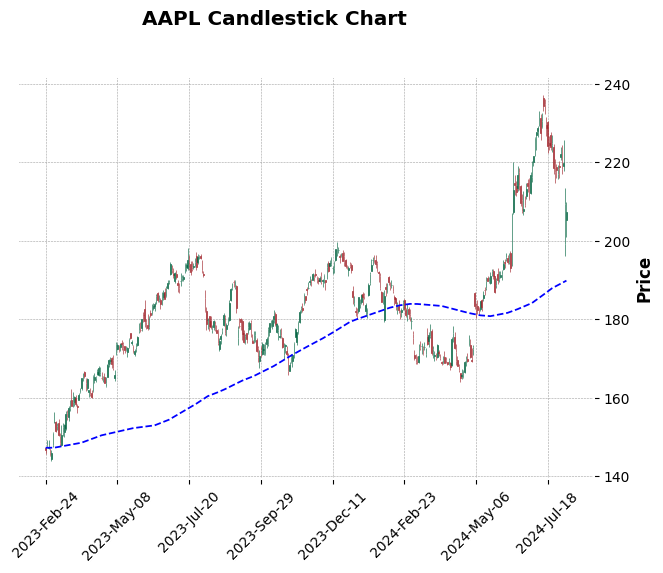

In [110]:
recent_data = prepare_data(stock_name)

In [115]:

X = recent_data.drop(columns=["Close", "movement","Volume"])
y = recent_data.drop(columns=["High","Low","Open","Volume", "last_close", "200_day", "Close"])
train_X,val_X,train_y,val_y = train_test_split(X,y,random_state = 1)
input_shape = [5]


early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape = input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(

    optimizer=optimizer,
    loss="mse",
)
EPOCHS = 1000
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=64,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0,
    
)



c:\Users\yahli\anaconda3\envs\Stocks\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
check_data = prepare_data(stock_name, "5d")

print(check_data)
check_X = check_data.drop(columns=["Close","Volume"])
# print(checl_data.head())
print(check_X.tail(1))

print(model.predict(check_X.tail(1)))
print(check_X.tail(1).Open[0] + model.predict(check_X.tail(1))[0])

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close     Volume  \
Date                                                                    
2024-08-01  224.369995  224.479996  217.020004  218.360001   62501000   
2024-08-02  219.149994  225.600006  217.710007  219.860001  105568600   
2024-08-05  199.089996  213.500000  196.000000  209.270004  119548600   
2024-08-06  205.300003  209.990005  201.070007  207.229996   69660500   
2024-08-07  206.899994  213.639999  206.389999  209.820007   63402300   

            last_close  
Date                    
2024-08-01         NaN  
2024-08-02  218.360001  
2024-08-05  219.860001  
2024-08-06  209.270004  
2024-08-07  207.229996  
                  Open        High         Low  last_close
Date                                                      
2024-08-07  206.899994  213.639999  206.389999  207.229996


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_105" is incompatible with the layer: expected axis -1 of input shape to have value 5, but received input with shape (1, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
  • training=False
  • mask=None

Minimum validation loss: 0.37492161989212036


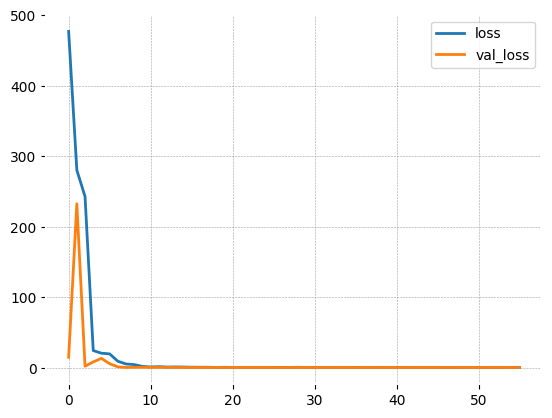

In [70]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))